<a href="https://colab.research.google.com/github/na-go/Prac_PyTorch/blob/master/Prac_PyTorch_Sec4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section4
## TOC
1. 畳み込みニューラルネットの定義
2. 独自画像データセットを畳み込みニューラルネットで分類

In [1]:
# Google Driveにマウント
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd gdrive/My Drive/Colab Notebooks/prac_Putorch

/content/gdrive/My Drive/Colab Notebooks/prac_Putorch


In [0]:
# モジュールのインポート
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# データの読み込み
train_dataset = torchvision.datasets.CIFAR10(root = "./data/",
                                             train = True,
                                             transform = transforms.ToTensor(),
                                             download = True
                                             )

test_dataset = torchvision.datasets.CIFAR10(root = "./data",
                                            train = False,
                                            transform = transforms.ToTensor(),
                                            download = True
                                            )
image, label = train_dataset[0]
print(image.size())
print(label)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
6


In [0]:
## Dataloaderの定義
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = 64,
                                           shuffle = True,
                                           num_workers = 2
                                           )
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size = 64,
                                          shuffle = False,
                                          num_workers = 2
                                          )

In [0]:
# ネットワーク定義
num_classes = 10 # 出力数の定義
## AlexNetの模倣
class AlexNet_trace(nn.Module):
  
  def __init__(self, num_classes = 10):
    super(AlexNet_trace, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
        nn.ReLU(inplace =True),
        nn.MaxPool2d(kernel_size= 2, stride = 2),
        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size= 2, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384,256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace= True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.classifier = nn.Linear(256, num_classes)

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x



device = "cuda" if torch.cuda.is_available() else "cpu" # GPUかCPU使用の選択
alexnet_trace = AlexNet_trace().to(device) # ネットワーク作成

criterion = nn.CrossEntropyLoss() # 損失関数としてクロスエントロピーを設定
optimizer = optim.SGD(alexnet_trace.parameters(), lr = 0.01, momentum = 0.9, weight_decay=5e-4) # 最適化にSGDを設定

In [11]:
# 学習
num_epochs = 20 # エポック数の定義, 今回は20

## 損失と正解率を保存するリスト
train_loss_list = []
train_acc_list = []
eval_loss_list = []
eval_acc_list = []

for epoch in range(num_epochs):
  # 損失と正解率の初期化
  train_loss = 0
  train_acc = 0
  eval_loss = 0
  eval_acc = 0

  #Trainingモードへ移行=======================
  alexnet_trace.train()
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = alexnet_trace(images)
    loss = criterion(outputs, labels)
    train_loss += loss.item()
    train_acc += (outputs.max(1)[1] == labels).sum().item()
    loss.backward()
    optimizer.step()

  average_train_loss = train_loss / len(train_loader.dataset)
  average_train_acc = train_acc / len(train_loader.dataset)

  #Evalationモードへ移行======================
  alexnet_trace.eval()
  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = alexnet_trace(images)
      loss = criterion(outputs, labels)
      eval_loss += loss.item()
      eval_acc += (outputs.max(1)[1] == labels).sum().item()

  average_eval_loss = eval_loss / len(test_loader.dataset)
  average_eval_acc = eval_acc / len(test_loader.dataset)
  print("Epoch [{}/{}], Loss: {loss:.4f}, eval_loss : {eval_loss:.4f}, eval_acc: {eval_acc:.4f}".format(epoch+1, num_epochs, i+1, loss = average_train_loss, eval_loss = average_eval_loss, eval_acc = average_eval_acc))
  train_loss_list.append(average_train_loss)
  train_acc_list.append(average_train_acc)
  eval_loss_list.append(average_eval_loss)
  eval_acc_list.append(average_eval_acc)



Epoch [1/20], Loss: 0.0277, eval_loss : 0.0251, eval_acc: 0.4117
Epoch [2/20], Loss: 0.0236, eval_loss : 0.0222, eval_acc: 0.4789
Epoch [3/20], Loss: 0.0212, eval_loss : 0.0202, eval_acc: 0.5323
Epoch [4/20], Loss: 0.0196, eval_loss : 0.0208, eval_acc: 0.5196
Epoch [5/20], Loss: 0.0181, eval_loss : 0.0186, eval_acc: 0.5752
Epoch [6/20], Loss: 0.0168, eval_loss : 0.0177, eval_acc: 0.5936
Epoch [7/20], Loss: 0.0156, eval_loss : 0.0179, eval_acc: 0.5985
Epoch [8/20], Loss: 0.0144, eval_loss : 0.0170, eval_acc: 0.6230
Epoch [9/20], Loss: 0.0132, eval_loss : 0.0168, eval_acc: 0.6293
Epoch [10/20], Loss: 0.0122, eval_loss : 0.0172, eval_acc: 0.6317
Epoch [11/20], Loss: 0.0113, eval_loss : 0.0177, eval_acc: 0.6194
Epoch [12/20], Loss: 0.0102, eval_loss : 0.0188, eval_acc: 0.6107
Epoch [13/20], Loss: 0.0094, eval_loss : 0.0184, eval_acc: 0.6158
Epoch [14/20], Loss: 0.0086, eval_loss : 0.0187, eval_acc: 0.6333
Epoch [15/20], Loss: 0.0078, eval_loss : 0.0192, eval_acc: 0.6410
Epoch [16/20], Loss

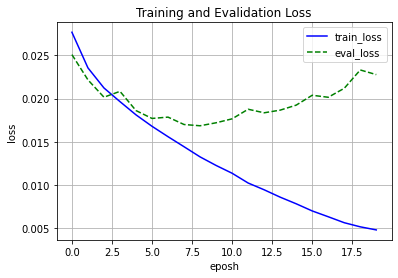

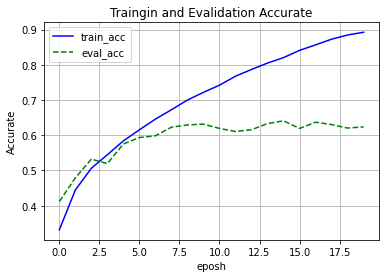

In [12]:
## 結果の可視化
### 損失
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color="blue", linestyle="-", label="train_loss")
plt.plot(range(num_epochs), eval_loss_list, color="green", linestyle="--", label = "eval_loss")
plt.legend()
plt.xlabel("eposh")
plt.ylabel("loss")
plt.title("Training and Evalidation Loss")
plt.grid()

### 正解率
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color="blue", linestyle="-", label="train_acc")
plt.plot(range(num_epochs), eval_acc_list, color="green", linestyle="--", label = "eval_acc")
plt.legend()
plt.xlabel("eposh")
plt.ylabel("Accurate")
plt.title("Traingin and Evalidation Accurate")
plt.grid()